## Example for reading BNS NR waveforms
The code below demonstrates how to use numerical relativity BNS waveforms from the lvcnr-matter repository.
The LAL part is identical to the BBH case, but the BNS case requires reading additional metadata (absolute masses). 
Also, there is an interface to read the waveform files without LAL.

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from waverep import save_gw_ligo as gwlvc

In [2]:
import lalsimulation as ls
import lal

MSUN_METER = lal.MSUN_SI * lal.G_SI/(lal.C_SI**2)
MSUN_SECOND = MSUN_METER / lal.C_SI

In [3]:
git_lvcnr_matter_dir = os.path.expanduser('/home/bgiacoma/homews/Documents/lvcnr-matter-master/')
catalog_dir = git_lvcnr_matter_dir + 'BNS/'
wf_file = catalog_dir + 'trento/EOS_H4/mgrav_1.40_1.40/EOS_H4_mgrav_1.40_1.40_Bfield_2e12_res_0.12/gw_EOS_H4_mgrav_1.40_1.40_Bfield_2e12_res_0.12.h5'

### Get metadata

we need to tell LAL the absolute masses since it does treat the BNS as BBH and requries the absolute masses from the user instead reading them from the waveform file. There is no need to deal with the raw hdf5 fromat, however, since there is a Python interface for reading waveform files (without LAL) in the lvcnr repo.

In [4]:
wff = gwlvc.WaveFormFile(wf_file)
m1  = wff.grav_mass1
m2  = wff.grav_mass2
mtotal = wff.grav_mass_sum
f_lower = wff.f_lower_msol / gwlvc.MSOL_SECONDS

print("""
f_lower [Hz] = %.5g 
m1 [M_SOL] = %.5f
m2 [M_SOL] = %.5f 
""" % (f_lower,m1,m2))


f_lower [Hz] = 564.21 
m1 [M_SOL] = 1.40000
m2 [M_SOL] = 1.40000 



### Get the strain 
One can get strain coefficients directly from waveform file without LAL using a Python interface in lvcnr-matter repo. The snippet below loads the raw complex-valued coefficients (for $l=m=2$ in this example) of the GW spin spherical harmonic decomposition.

In [5]:
deltaT = 1.0/40000. # sample rate
ct,ch = wff.strain_units_msol(2,2, samp_rate=MSUN_SECOND/deltaT)
ct = ct - ct[0]

To compute the strain at some inclination, we need to evaluate the spin weighted spherical harmonic coefficient and scale the amplitude to the distance. We assume zero inclination for simplicity.

In [6]:
inclination=0

#distance
dist_mpc = 100.
distance = dist_mpc * lal.PC_SI * 1.0e6

fac = np.abs(lal.SpinWeightedSphericalHarmonic(inclination,0,-2,2,2))

In [7]:
time = ct * MSUN_SECOND #in seconds
strain_plus = fac * ch.real * MSUN_METER / distance
strain_cross = fac * ch.imag * MSUN_METER / distance

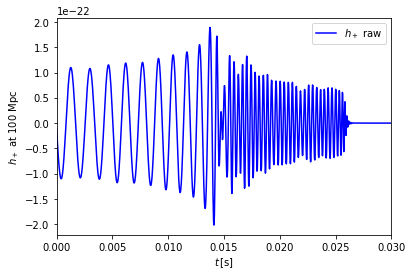

In [8]:
plt.plot(time, strain_plus, 'b-',  label=r'$h_+$ raw')
plt.legend()
plt.xlabel(r'$t \, [\mathrm{s}]$')
plt.ylabel(r'$h_+$ at $%.f$ Mpc' % dist_mpc)
plt.xlim(0,0.030);

In [9]:
ts = time[1] - time[0] #-- Time between samples
fs = int(1.0 / ts)          #-- Sampling frequency
print('frequency (in Hz)=',fs)

frequency (in Hz)= 40021


In [10]:
freq_domain_plus = np.fft.rfft(strain_plus) / fs
freq_domain_cross = np.fft.rfft(strain_cross) / fs
freq = np.fft.rfftfreq(len(strain_plus))*fs

$ h_{eff} \equiv \sqrt{\tilde{h}_+^2(f)+\tilde{h}_\times^2(f)} $ where $\tilde{h}_+$ and $\tilde{h}_\times$ are the Fourier transforms of the strain (plus and cross polarization, respectively).

In [11]:
heff = np.sqrt(freq)*np.sqrt(abs(freq_domain_plus)**2+abs(freq_domain_cross)**2)

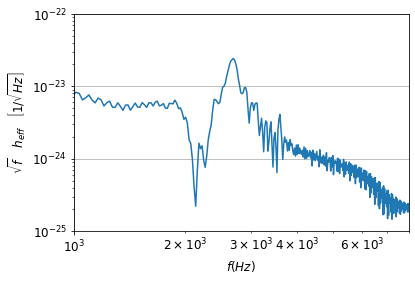

In [12]:
plt.rcParams.update({'font.size': 12})
plt.loglog(freq, heff)
#plt.axis([10, fs/2.0, 1e-24, 1e-18])
plt.xlim([1000, 8000])
plt.ylim([1e-25, 1e-22])
plt.grid('on')
plt.xlabel(r'$f (Hz)$')
plt.ylabel(r'$\sqrt{f}\quad h_{eff} \quad \left[1/\sqrt{Hz}\right]$')
plt.show()

### Output to Data File

In [13]:
data_table=np.c_[freq, heff]

In [14]:
#print the first 10 rows
print(data_table[:10,:])

[[0.00000000e+00 0.00000000e+00]
 [2.15282410e+01 1.43402673e-25]
 [4.30564820e+01 2.04239319e-25]
 [6.45847230e+01 2.52795088e-25]
 [8.61129640e+01 2.96843064e-25]
 [1.07641205e+02 3.38650868e-25]
 [1.29169446e+02 3.80168235e-25]
 [1.50697687e+02 4.22984573e-25]
 [1.72225928e+02 4.67599424e-25]
 [1.93754169e+02 5.15404588e-25]]


In [15]:
# We save the table in a human-readable format
np.savetxt('./ASD.txt',data_table,
           header='Freq (Hz) \t ASD (1/sqrt(Hz)) ',
           delimiter='\t',
           fmt='%1.3e')

In [16]:
!head ASD.txt

# Freq (Hz) 	 ASD (1/sqrt(Hz)) 
0.000e+00	0.000e+00
2.153e+01	1.434e-25
4.306e+01	2.042e-25
6.458e+01	2.528e-25
8.611e+01	2.968e-25
1.076e+02	3.387e-25
1.292e+02	3.802e-25
1.507e+02	4.230e-25
1.722e+02	4.676e-25
